<a href="https://colab.research.google.com/github/ekvirika/WalmartRecruiting/blob/main/notebooks/model_experiment_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install wandb torch torchvision pandas matplotlib seaborn scikit-learn mlflow

# Set up Kaggle API
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.

In [3]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip -q walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 518MB/s]


In [5]:
!unzip -q train.csv.zip
!unzip -q stores.csv.zip
!unzip -q test.csv.zip
!unzip -q features.csv.zip

unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.


In [6]:
!pip install dagshub mlflow --quiet
!pip install optuna
!pip install pmdarima
# !pip install --upgrade numpy scipy statsmodels pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.4 MB/s eta 0:00:00


In [43]:
!git clone https://github.com/ekvirika/WalmartRecruiting.git

Cloning into 'WalmartRecruiting'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 382 (delta 106), reused 41 (delta 16), pack-reused 208 (from 1)
Receiving objects: 100% (382/382), 21.91 MiB | 3.99 MiB/s, done.
Resolving deltas: 100% (233/233), done.


In [44]:
%cd WalmartRecruiting/


/content/WalmartRecruiting


In [40]:
# Removed sys.path.append("content/WalmartRecruiting") as it is no longer necessary after changing the working directory.

In [45]:
from helpers.data_loading import WalmartDataLoader
from helpers.data_preprocessing import WalmartDataPreprocessor
from helpers.mlflow_logger import MLflowDagsHubLogger

ImportError: cannot import name 'WalmartDataLoader' from 'helpers.data_loading' (/content/WalmartRecruiting/helpers/data_loading.py)

In [8]:
"""
MLflow Configuration with DagsHub Integration
For Walmart Sales Forecasting Project
"""

import mlflow
import mlflow.sklearn
import mlflow.pytorch
import dagshub
import os
from typing import Dict, Any, Optional
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import tempfile

class MLflowDagsHubLogger:
    """
    Comprehensive MLflow logger with DagsHub integration for time series forecasting
    """

    def __init__(self,
                 dagshub_repo_owner: str,
                 dagshub_repo_name: str,
                 dagshub_token: str = None):
        """
        Initialize MLflow with DagsHub integration

        Args:
            dagshub_repo_owner: Your DagsHub username
            dagshub_repo_name: Repository name on DagsHub
            dagshub_token: DagsHub authentication token
        """
        self.dagshub_repo_owner = dagshub_repo_owner
        self.dagshub_repo_name = dagshub_repo_name

        # Set up DagsHub
        dagshub.init(repo_owner=dagshub_repo_owner,
                    repo_name=dagshub_repo_name,
                    mlflow=True)

        # Set MLflow tracking URI to DagsHub
        mlflow_tracking_uri = f"https://dagshub.com/{dagshub_repo_owner}/{dagshub_repo_name}.mlflow"
        mlflow.set_tracking_uri(mlflow_tracking_uri)

        # Set authentication if token provided
        if dagshub_token:
            os.environ['MLFLOW_TRACKING_USERNAME'] = dagshub_token
            os.environ['MLFLOW_TRACKING_PASSWORD'] = ""

        self.current_experiment = None
        self.current_run = None

    def create_experiment(self, experiment_name: str) -> str:
        """
        Create or get existing MLflow experiment

        Args:
            experiment_name: Name of the experiment

        Returns:
            experiment_id: ID of the created/existing experiment
        """
        try:
            experiment_id = mlflow.create_experiment(experiment_name)
        except mlflow.exceptions.MlflowException:
            # Experiment already exists
            experiment = mlflow.get_experiment_by_name(experiment_name)
            experiment_id = experiment.experiment_id

        self.current_experiment = experiment_name
        mlflow.set_experiment(experiment_name)
        return experiment_id

    def start_run(self, run_name: str, nested: bool = False) -> mlflow.ActiveRun:
        """
        Start a new MLflow run

        Args:
            run_name: Name of the run
            nested: Whether this is a nested run

        Returns:
            Active MLflow run
        """
        self.current_run = mlflow.start_run(run_name=run_name, nested=nested)
        return self.current_run

    def log_preprocessing_step(self,
                              step_name: str,
                              input_shape: tuple,
                              output_shape: tuple,
                              preprocessing_params: Dict[str, Any] = None,
                              data_quality_metrics: Dict[str, Any] = None):
        """
        Log preprocessing step information

        Args:
            step_name: Name of preprocessing step
            input_shape: Shape of input data
            output_shape: Shape of output data
            preprocessing_params: Parameters used in preprocessing
            data_quality_metrics: Data quality metrics
        """
        with mlflow.start_run(run_name=f"{step_name}_preprocessing", nested=True):
            # Log shapes
            mlflow.log_param("input_rows", input_shape[0])
            mlflow.log_param("input_cols", input_shape[1] if len(input_shape) > 1 else 1)
            mlflow.log_param("output_rows", output_shape[0])
            mlflow.log_param("output_cols", output_shape[1] if len(output_shape) > 1 else 1)

            # Log preprocessing parameters
            if preprocessing_params:
                for key, value in preprocessing_params.items():
                    mlflow.log_param(f"preprocess_{key}", value)

            # Log data quality metrics
            if data_quality_metrics:
                for key, value in data_quality_metrics.items():
                    mlflow.log_metric(f"data_quality_{key}", value)

            # Log step completion
            mlflow.log_metric("preprocessing_completed", 1)

    def log_feature_engineering(self,
                               features_before: list,
                               features_after: list,
                               feature_importance: Dict[str, float] = None,
                               feature_selection_method: str = None):
        """
        Log feature engineering information

        Args:
            features_before: List of features before engineering
            features_after: List of features after engineering
            feature_importance: Feature importance scores
            feature_selection_method: Method used for feature selection
        """
        with mlflow.start_run(run_name="feature_engineering", nested=True):
            # Log feature counts
            mlflow.log_param("features_before_count", len(features_before))
            mlflow.log_param("features_after_count", len(features_after))

            # Log feature names
            mlflow.log_param("features_before", str(features_before[:20]))  # Limit to first 20
            mlflow.log_param("features_after", str(features_after[:20]))   # Limit to first 20

            # Log feature selection method
            if feature_selection_method:
                mlflow.log_param("feature_selection_method", feature_selection_method)

            # Log feature importance
            if feature_importance:
                for feature, importance in list(feature_importance.items())[:20]:  # Top 20
                    mlflow.log_metric(f"feature_importance_{feature}", importance)

    def log_model_training(self,
                          model,
                          model_params: Dict[str, Any],
                          training_metrics: Dict[str, float],
                          validation_metrics: Dict[str, float],
                          model_name: str,
                          tags: Dict[str, str] = None):
        """
        Log model training information

        Args:
            model: Trained model object
            model_params: Model hyperparameters
            training_metrics: Training metrics
            validation_metrics: Validation metrics
            model_name: Name of the model
            tags: Additional tags for the run
        """
        # Log parameters
        for key, value in model_params.items():
            mlflow.log_param(key, value)

        # Log training metrics
        for key, value in training_metrics.items():
            mlflow.log_metric(f"train_{key}", value)

        # Log validation metrics
        for key, value in validation_metrics.items():
            mlflow.log_metric(f"val_{key}", value)

        # Log model
        if hasattr(model, 'predict'):
            if isinstance(model, Pipeline):
                mlflow.sklearn.log_model(model, model_name)
            else:
                # Handle different model types
                if hasattr(model, '__module__'):
                    if 'torch' in model.__module__:
                        mlflow.pytorch.log_model(model, model_name)
                    elif 'sklearn' in model.__module__:
                        mlflow.sklearn.log_model(model, model_name)
                    else:
                        # Generic model logging
                        with tempfile.NamedTemporaryFile(suffix='.pkl', delete=False) as tmp:
                            joblib.dump(model, tmp.name)
                            mlflow.log_artifact(tmp.name, f"{model_name}.pkl")

        # Log tags
        if tags:
            mlflow.set_tags(tags)

    def log_cross_validation(self,
                           cv_scores: Dict[str, list],
                           cv_method: str,
                           n_folds: int):
        """
        Log cross-validation results

        Args:
            cv_scores: Dictionary of CV scores for each metric
            cv_method: Cross-validation method used
            n_folds: Number of folds
        """
        with mlflow.start_run(run_name="cross_validation", nested=True):
            mlflow.log_param("cv_method", cv_method)
            mlflow.log_param("n_folds", n_folds)

            for metric_name, scores in cv_scores.items():
                mlflow.log_metric(f"cv_{metric_name}_mean", np.mean(scores))
                mlflow.log_metric(f"cv_{metric_name}_std", np.std(scores))
                mlflow.log_metric(f"cv_{metric_name}_min", np.min(scores))
                mlflow.log_metric(f"cv_{metric_name}_max", np.max(scores))

                # Log individual fold scores
                for i, score in enumerate(scores):
                    mlflow.log_metric(f"cv_{metric_name}_fold_{i+1}", score)

    def log_hyperparameter_tuning(self,
                                 best_params: Dict[str, Any],
                                 best_score: float,
                                 tuning_method: str,
                                 search_space: Dict[str, Any] = None,
                                 n_trials: int = None):
        """
        Log hyperparameter tuning results

        Args:
            best_params: Best parameters found
            best_score: Best score achieved
            tuning_method: Method used for tuning
            search_space: Search space definition
            n_trials: Number of trials performed
        """
        with mlflow.start_run(run_name="hyperparameter_tuning", nested=True):
            mlflow.log_param("tuning_method", tuning_method)
            if n_trials:
                mlflow.log_param("n_trials", n_trials)

            # Log best parameters
            for key, value in best_params.items():
                mlflow.log_param(f"best_{key}", value)

            mlflow.log_metric("best_score", best_score)

            # Log search space
            if search_space:
                for key, value in search_space.items():
                    mlflow.log_param(f"search_space_{key}", str(value))

    def log_time_series_metrics(self,
                               y_true: np.ndarray,
                               y_pred: np.ndarray,
                               is_holiday: np.ndarray = None,
                               prefix: str = ""):
        """
        Log time series specific metrics

        Args:
            y_true: True values
            y_pred: Predicted values
            is_holiday: Holiday indicator for WMAE calculation
            prefix: Prefix for metric names
        """
        prefix = f"{prefix}_" if prefix else ""

        # Standard metrics
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)

        mlflow.log_metric(f"{prefix}mae", mae)
        mlflow.log_metric(f"{prefix}mse", mse)
        mlflow.log_metric(f"{prefix}rmse", rmse)

        # MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
        mlflow.log_metric(f"{prefix}mape", mape)

        # WMAE (Weighted Mean Absolute Error) if holiday data available
        if is_holiday is not None:
            weights = np.where(is_holiday, 5, 1)
            wmae = np.average(np.abs(y_true - y_pred), weights=weights)
            mlflow.log_metric(f"{prefix}wmae", wmae)

    def register_best_model(self,
                           model_name: str,
                           model_version: str,
                           model_stage: str = "Staging"):
        """
        Register the best model in MLflow Model Registry

        Args:
            model_name: Name for the registered model
            model_version: Version of the model
            model_stage: Stage of the model (Staging, Production, etc.)
        """
        try:
            # Create registered model
            mlflow.register_model(
                model_uri=f"runs:/{self.current_run.info.run_id}/{model_name}",
                name=model_name
            )

            # Transition to specified stage
            client = mlflow.tracking.MlflowClient()
            client.transition_model_version_stage(
                name=model_name,
                version=model_version,
                stage=model_stage
            )

            print(f"Model {model_name} version {model_version} registered and moved to {model_stage}")

        except Exception as e:
            print(f"Error registering model: {e}")

    def end_run(self):
        """End the current MLflow run"""
        if self.current_run:
            mlflow.end_run()
            self.current_run = None

# Utility function for WMAE calculation
def calculate_wmae(y_true: np.ndarray, y_pred: np.ndarray, is_holiday: np.ndarray) -> float:
    """
    Calculate Weighted Mean Absolute Error

    Args:
        y_true: True values
        y_pred: Predicted values
        is_holiday: Holiday indicator (1 for holiday, 0 for non-holiday)

    Returns:
        WMAE score
    """
    weights = np.where(is_holiday, 5, 1)
    return np.average(np.abs(y_true - y_pred), weights=weights)

# Example usage configuration
def setup_mlflow_logging(dagshub_repo_owner: str,
                        dagshub_repo_name: str,
                        dagshub_token: str = None) -> MLflowDagsHubLogger:
    """
    Setup MLflow logging with DagsHub

    Args:
        dagshub_repo_owner: Your DagsHub username
        dagshub_repo_name: Repository name
        dagshub_token: Authentication token

    Returns:
        Configured logger instance
    """
    logger = MLflowDagsHubLogger(
        dagshub_repo_owner=dagshub_repo_owner,
        dagshub_repo_name=dagshub_repo_name,
        dagshub_token=dagshub_token
    )

    return logger

In [7]:
# model_experiment_ARIMA.ipynb
"""
ARIMA Model Experiment with Comprehensive MLflow Logging
Walmart Sales Forecasting Project
"""

# =============================================================================
# SETUP AND IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import your existing modules
from src import data_loader, processing
from feature_engineering import feature_transformers, time_features
from feature_engineering.encoders import CustomOneHotEncoder
from models import store_dept_sarimax
from src.utils import wmae as compute_wmae

# Import our MLflow configuration
from mlflow_dagshub_config import MLflowDagsHubLogger, calculate_wmae, setup_mlflow_logging

# =============================================================================
# MLFLOW SETUP WITH DAGSHUB
# =============================================================================

# TODO: Replace with your actual DagsHub credentials
DAGSHUB_REPO_OWNER = "ekvirika"  # Your DagsHub username
DAGSHUB_REPO_NAME = "WalmartRecruiting"  # Your repository name
DAGSHUB_TOKEN = "0adb1004ddd4221395353efea2d8ead625e26197"  # Your DagsHub token (optional, can use env var)

# Initialize MLflow logger
logger = setup_mlflow_logging(
    dagshub_repo_owner=DAGSHUB_REPO_OWNER,
    dagshub_repo_name=DAGSHUB_REPO_NAME,
    dagshub_token=DAGSHUB_TOKEN
)

# Create experiment for ARIMA models
experiment_id = logger.create_experiment("ARIMA_Training")

# =============================================================================
# DATA LOADING AND INITIAL PREPROCESSING
# =============================================================================

def load_and_preprocess_data():
    """Load and preprocess the data with logging"""

    with logger.start_run("ARIMA_Data_Loading"):
        # Load raw data
        dataframes = data_loader.load_raw_data()
        df = processing.run_preprocessing(dataframes, process_test=False)['train']

        # Log data loading metrics
        logger.log_preprocessing_step(
            step_name="data_loading",
            input_shape=(len(df), len(df.columns)),
            output_shape=(len(df), len(df.columns)),
            data_quality_metrics={
                "total_rows": len(df),
                "total_columns": len(df.columns),
                "missing_values_ratio": df.isnull().sum().sum() / (len(df) * len(df.columns)),
                "unique_stores": df['Store'].nunique(),
                "unique_departments": df['Dept'].nunique(),
                "date_range_days": (df['Date'].max() - df['Date'].min()).days
            }
        )

        # Split data
        X_train, y_train, X_valid, y_valid = processing.split_data(df, separate_target=True)

        # Log split information
        logger.log_preprocessing_step(
            step_name="train_test_split",
            input_shape=(len(df), len(df.columns)),
            output_shape=(len(X_train) + len(X_valid), len(X_train.columns)),
            preprocessing_params={
                "train_size": len(X_train),
                "valid_size": len(X_valid),
                "split_ratio": len(X_train) / (len(X_train) + len(X_valid))
            }
        )

        mlflow.log_metric("data_loading_completed", 1)

    return X_train, y_train, X_valid, y_valid

# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

def create_preprocessing_pipeline():
    """Create and log preprocessing pipeline"""

    with logger.start_run("ARIMA_Feature_Engineering"):
        # Define preprocessing steps
        columns_to_drop = [
            'MarkDown1', 'MarkDown2', 'MarkDown3',
            'MarkDown4', 'MarkDown5'
        ]

        time_feature_params = {
            'add_week_num': True,
            'add_holiday_flags': False,
            'add_holiday_proximity': True,
            'add_holiday_windows': False,
            'add_fourier_features': True,
            'add_month_and_year': True,
            'replace_time_index': False,
            'list_of_holiday_proximity': [],
        }

        # Create pipeline
        preprocess_pipeline = Pipeline(steps=[
            ('drop_markdown', feature_transformers.ChangeColumns(columns_to_drop=columns_to_drop)),
            ('bool_to_int', feature_transformers.BoolToInt()),
            ('type_encoding', CustomOneHotEncoder(columns=['Type'])),
            ('add_time_features', time_features.FeatureAdder(**time_feature_params)),
        ])

        # Log preprocessing parameters
        preprocessing_params = {
            "columns_dropped": len(columns_to_drop),
            "boolean_conversion": True,
            "one_hot_encoding": True,
            "time_features_added": len([k for k, v in time_feature_params.items() if v and isinstance(v, bool)])
        }

        for key, value in preprocessing_params.items():
            mlflow.log_param(f"preprocessing_{key}", value)

        for key, value in time_feature_params.items():
            mlflow.log_param(f"time_feature_{key}", value)

        mlflow.log_metric("feature_engineering_completed", 1)

    return preprocess_pipeline

def apply_feature_engineering(X_train, X_valid, preprocess_pipeline):
    """Apply feature engineering with logging"""

    with logger.start_run("ARIMA_Feature_Application"):
        # Get original features
        original_features = X_train.columns.tolist()

        # Apply preprocessing
        X_train_processed = preprocess_pipeline.fit_transform(X_train)
        X_valid_processed = preprocess_pipeline.transform(X_valid)

        # Get new features
        new_features = X_train_processed.columns.tolist()

        # Log feature engineering
        logger.log_feature_engineering(
            features_before=original_features,
            features_after=new_features,
            feature_selection_method="manual_selection_and_engineering"
        )

        # Log shape changes
        logger.log_preprocessing_step(
            step_name="feature_transformation",
            input_shape=X_train.shape,
            output_shape=X_train_processed.shape,
            preprocessing_params={
                "features_added": len(new_features) - len(original_features),
                "transformation_steps": len(preprocess_pipeline.steps)
            }
        )

        mlflow.log_metric("feature_application_completed", 1)

    return X_train_processed, X_valid_processed

# =============================================================================
# SUBSET SELECTION FOR EFFICIENT TRAINING
# =============================================================================

def select_subset_for_training(X_train, X_valid, y_train, y_valid, n_combinations=100):
    """Select subset of store-department combinations for training"""

    with logger.start_run("ARIMA_Subset_Selection"):
        # Reset indices
        X_train_reset = X_train.reset_index(drop=True)
        X_valid_reset = X_valid.reset_index(drop=True)
        y_train_reset = y_train.reset_index(drop=True)
        y_valid_reset = y_valid.reset_index(drop=True)

        # Select subset
        subset_keys = X_train_reset[['Store', 'Dept']].drop_duplicates().sample(
            n=n_combinations, random_state=42
        )

        # Filter data
        X_train_subset = pd.merge(X_train_reset, subset_keys, on=['Store', 'Dept'], how='inner')
        X_valid_subset = pd.merge(X_valid_reset, subset_keys, on=['Store', 'Dept'], how='inner')

        y_train_subset = y_train_reset.iloc[X_train_subset.index]
        y_valid_subset = y_valid_reset.iloc[X_valid_subset.index]

        # Log subset selection parameters
        mlflow.log_param("subset_combinations", n_combinations)
        mlflow.log_param("original_train_size", len(X_train_reset))
        mlflow.log_param("subset_train_size", len(X_train_subset))
        mlflow.log_param("original_valid_size", len(X_valid_reset))
        mlflow.log_param("subset_valid_size", len(X_valid_subset))
        mlflow.log_param("subset_ratio", len(X_train_subset) / len(X_train_reset))

        # Log data quality metrics for subset
        data_quality_metrics = {
            "subset_coverage": n_combinations / X_train_reset[['Store', 'Dept']].drop_duplicates().shape[0],
            "stores_in_subset": X_train_subset['Store'].nunique(),
            "departments_in_subset": X_train_subset['Dept'].nunique()
        }

        for key, value in data_quality_metrics.items():
            mlflow.log_metric(key, value)

        mlflow.log_metric("subset_selection_completed", 1)

    return X_train_subset, X_valid_subset, y_train_subset, y_valid_subset

# =============================================================================
# ARIMA MODEL TRAINING
# =============================================================================

def train_arima_model(X_train, X_valid, y_train, y_valid, order=(1, 1, 1)):
    """Train ARIMA model with comprehensive logging"""

    run_name = f"ARIMA_Training_order_{order[0]}_{order[1]}_{order[2]}"

    with logger.start_run(run_name):
        # Prepare data for ARIMA (only Date, Store, Dept needed)
        X_train_arima = X_train[['Date', 'Store', 'Dept']]
        X_valid_arima = X_valid[['Date', 'Store', 'Dept']]

        # Initialize model
        arima_model = store_dept_sarimax.StoreDeptSARIMAX(
            order=order,
            use_all_exog=False,
        )

        # Log model parameters
        model_params = {
            "model_type": "ARIMA",
            "order_p": order[0],
            "order_d": order[1],
            "order_q": order[2],
            "use_exogenous_variables": False,
            "seasonal": False
        }

        # Train model
        print(f"Training ARIMA model with order {order}...")
        start_time = datetime.now()

        arima_model.fit(X_train_arima, y_train)

        training_time = (datetime.now() - start_time).total_seconds()
        model_params["training_time_seconds"] = training_time

        # Make predictions
        train_preds = arima_model.predict(X_train_arima).fillna(0)
        valid_preds = arima_model.predict(X_valid_arima).fillna(0)

        # Calculate metrics
        train_metrics = {
            "mae": mean_absolute_error(y_train, train_preds),
            "mse": mean_squared_error(y_train, train_preds),
            "rmse": np.sqrt(mean_squared_error(y_train, train_preds)),
            "wmae": calculate_wmae(y_train.values, train_preds.values, X_train['IsHoliday'].values)
        }

        valid_metrics = {
            "mae": mean_absolute_error(y_valid, valid_preds),
            "mse": mean_squared_error(y_valid, valid_preds),
            "rmse": np.sqrt(mean_squared_error(y_valid, valid_preds)),
            "wmae": calculate_wmae(y_valid.values, valid_preds.values, X_valid['IsHoliday'].values)
        }

        # Create full pipeline
        full_pipeline = Pipeline([
            ('preprocess', preprocess_pipeline),
            ('model', arima_model)
        ])

        # Log everything
        logger.log_model_training(
            model=full_pipeline,
            model_params=model_params,
            training_metrics=train_metrics,
            validation_metrics=valid_metrics,
            model_name="arima_model",
            tags={
                "model_family": "ARIMA",
                "experiment_type": "baseline",
                "data_subset": "store_dept_sample"
            }
        )

        # Log time series specific metrics
        logger.log_time_series_metrics(
            y_true=y_train.values,
            y_pred=train_preds.values,
            is_holiday=X_train['IsHoliday'].values,
            prefix="train"
        )

        logger.log_time_series_metrics(
            y_true=y_valid.values,
            y_pred=valid_preds.values,
            is_holiday=X_valid['IsHoliday'].values,
            prefix="valid"
        )

        print(f"ARIMA {order} - Train WMAE: {train_metrics['wmae']:.2f}, Valid WMAE: {valid_metrics['wmae']:.2f}")

        return full_pipeline, valid_metrics['wmae']

# =============================================================================
# SARIMA MODEL TRAINING
# =============================================================================

def train_sarima_model(X_train, X_valid, y_train, y_valid,
                      order=(1, 1, 1), seasonal_order=(1, 1, 1, 52)):
    """Train SARIMA model with comprehensive logging"""

    run_name = f"SARIMA_Training_order_{order[0]}_{order[1]}_{order[2]}_seasonal_{seasonal_order[0]}_{seasonal_order[1]}_{seasonal_order[2]}_{seasonal_order[3]}"

    with logger.start_run(run_name):
        # Prepare data for SARIMA
        X_train_sarima = X_train[['Date', 'Store', 'Dept']]
        X_valid_sarima = X_valid[['Date', 'Store', 'Dept']]

        # Initialize model
        sarima_model = store_dept_sarimax.StoreDeptSARIMAX(
            order=order,
            seasonal_order=seasonal_order,
            use_all_exog=False
        )

        # Log model parameters
        model_params = {
            "model_type": "SARIMA",
            "order_p": order[0],
            "order_d": order[1],
            "order_q": order[2],
            "seasonal_p": seasonal_order[0],
            "seasonal_d": seasonal_order[1],
            "seasonal_q": seasonal_order[2],
            "seasonal_period": seasonal_order[3],
            "use_exogenous_variables": False,
            "seasonal": True
        }

        # Train model
        print(f"Training SARIMA model with order {order} and seasonal {seasonal_order}...")
        start_time = datetime.now()

        sarima_model.fit(X_train_sarima, y_train)

        training_time = (datetime.now() - start_time).total_seconds()
        model_params["training_time_seconds"] = training_time

        # Make predictions
        train_preds = sarima_model.predict(X_train_sarima).fillna(0)
        valid_preds = sarima_model.predict(X_valid_sarima).fillna(0)

        # Calculate metrics
        train_metrics = {
            "mae": mean_absolute_error(y_train, train_preds),
            "mse": mean_squared_error(y_train, train_preds),
            "rmse": np.sqrt(mean_squared_error(y_train, train_preds)),
            "wmae": calculate_wmae(y_train.values, train_preds.values, X_train['IsHoliday'].values)
        }

        valid_metrics = {
            "mae": mean_absolute_error(y_valid, valid_preds),
            "mse": mean_squared_error(y_valid, valid_preds),
            "rmse": np.sqrt(mean_squared_error(y_valid, valid_preds)),
            "wmae": calculate_wmae(y_valid.values, valid_preds.values, X_valid['IsHoliday'].values)
        }

        # Create full pipeline
        full_pipeline = Pipeline([
            ('preprocess', preprocess_pipeline),
            ('model', sarima_model)
        ])

        # Log everything
        logger.log_model_training(
            model=full_pipeline,
            model_params=model_params,
            training_metrics=train_metrics,
            validation_metrics=valid_metrics,
            model_name="sarima_model",
            tags={
                "model_family": "SARIMA",
                "experiment_type": "seasonal_baseline",
                "data_subset": "store_dept_sample"
            }
        )

        # Log time series specific metrics
        logger.log_time_series_metrics(
            y_true=y_train.values,
            y_pred=train_preds.values,
            is_holiday=X_train['IsHoliday'].values,
            prefix="train"
        )

        logger.log_time_series_metrics(
            y_true=y_valid.values,
            y_pred=valid_preds.values,
            is_holiday=X_valid['IsHoliday'].values,
            prefix="valid"
        )

        print(f"SARIMA {order} {seasonal_order} - Train WMAE: {train_metrics['wmae']:.2f}, Valid WMAE: {valid_metrics['wmae']:.2f}")

        return full_pipeline, valid_metrics['wmae']

# =============================================================================
# SARIMAX MODEL TRAINING
# =============================================================================

def train_sarimax_model(X_train, X_valid, y_train, y_valid,
                       order=(1, 1, 1), seasonal_order=(1, 1, 1, 52)):
    """Train SARIMAX model with comprehensive logging"""

    run_name = f"SARIMAX_Training_order_{order[0]}_{order[1]}_{order[2]}_seasonal_{seasonal_order[0]}_{seasonal_order[1]}_{seasonal_order[2]}_{seasonal_order[3]}"

    with logger.start_run(run_name):
        # Initialize model with exogenous variables
        sarimax_model = store_dept_sarimax.StoreDeptSARIMAX(
            order=order,
            seasonal_order=seasonal_order,
            use_all_exog=True
        )

        # Log model parameters
        model_params = {
            "model_type": "SARIMAX",
            "order_p": order[0],
            "order_d": order[1],
            "order_q": order[2],
            "seasonal_p": seasonal_order[0],
            "seasonal_d": seasonal_order[1],
            "seasonal_q": seasonal_order[2],
            "seasonal_period": seasonal_order[3],
            "use_exogenous_variables": True,
            "seasonal": True,
            "exogenous_features": X_train.columns.tolist()
        }

        # Train model
        print(f"Training SARIMAX model with order {order} and seasonal {seasonal_order}...")
        start_time = datetime.now()

        sarimax_model.fit(X_train, y_train)

        training_time = (datetime.now() - start_time).total_seconds()
        model_params["training_time_seconds"] = training_time

        # Make predictions
        train_preds = sarimax_model.predict(X_train).fillna(0)
        valid_preds = sarimax_model.predict(X_valid).fillna(0)

        # Calculate metrics
        train_metrics = {
            "mae": mean_absolute_error(y_train, train_preds),
            "mse": mean_squared_error(y_train, train_preds),
            "rmse": np.sqrt(mean_squared_error(y_train, train_preds)),
            "wmae": calculate_wmae(y_train.values, train_preds.values, X_train['IsHoliday'].values)
        }

        valid_metrics = {
            "mae": mean_absolute_error(y_valid, valid_preds),
            "mse": mean_squared_error(y_valid, valid_preds),
            "rmse": np.sqrt(mean_squared_error(y_valid, valid_preds)),
            "wmae": calculate_wmae(y_valid.values, valid_preds.values, X_valid['IsHoliday'].values)
        }

        # Create full pipeline
        full_pipeline = Pipeline([
            ('preprocess', preprocess_pipeline),
            ('model', sarimax_model)
        ])

        # Log everything
        logger.log_model_training(
            model=full_pipeline,
            model_params=model_params,
            training_metrics=train_metrics,
            validation_metrics=valid_metrics,
            model_name="sarimax_model",
            tags={
                "model_family": "SARIMAX",
                "experiment_type": "exogenous_variables",
                "data_subset": "store_dept_sample"
            }
        )

        # Log time series specific metrics
        logger.log_time_series_metrics(
            y_true=y_train.values,
            y_pred=train_preds.values,
            is_holiday=X_train['IsHoliday'].values,
            prefix="train"
        )

        logger.log_time_series_metrics(
            y_true=y_valid.values,
            y_pred=valid_preds.values,
            is_holiday=X_valid['IsHoliday'].values,
            prefix="valid"
        )

        print(f"SARIMAX {order} {seasonal_order} - Train WMAE: {train_metrics['wmae']:.2f}, Valid WMAE: {valid_metrics['wmae']:.2f}")

        return full_pipeline, valid_metrics['wmae']

# =============================================================================
# HYPERPARAMETER TUNING
# =============================================================================

def hyperparameter_tuning_arima(X_train, X_valid, y_train, y_valid):
    """Perform hyperparameter tuning for ARIMA models"""

    with logger.start_run("ARIMA_Hyperparameter_Tuning"):
        # Define search space
        search_space = {
            "p_values": [0, 1, 2],
            "d_values": [1],
            "q_values": [0, 1, 2]
        }

        best_score = float('inf')
        best_params = None
        best_pipeline = None

        results = []

        # Grid search
        for p in search_space["p_values"]:
            for d in search_space["d_values"]:
                for q in search_space["q_values"]:
                    try:
                        order = (p, d, q)
                        pipeline, score = train_arima_model(X_train, X_valid, y_train, y_valid, order)

                        results.append({
                            "p": p, "d": d, "q": q,
                            "score": score
                        })

                        if score < best_score:
                            best_score = score
                            best_params = {"p": p, "d": d, "q": q}
                            best_pipeline = pipeline

                        print(f"ARIMA({p},{d},{q}) - Score: {score:.2f}")

                    except Exception as e:
                        print(f"Error with ARIMA({p},{d},{q}): {e}")
                        continue

        # Log hyperparameter tuning results
        logger.log_hyperparameter_tuning(
            best_params=best_params,
            best_score=best_score,
            tuning_method="grid_search",
            search_space=search_space,
            n_trials=len(results)
        )

        # Log all trial results
        for i, result in enumerate(results):
            mlflow.log_metric(f"trial_{i}_score", result["score"])
            mlflow.log_param(f"trial_{i}_params", str(result))

        return best_pipeline, best_params, best_score

# =============================================================================
# CROSS VALIDATION
# =============================================================================

def time_series_cross_validation(X_train, y_train, model_func, n_splits=3):
    """Perform time series cross validation"""

    with logger.start_run("ARIMA_Cross_Validation"):
        # Simple time series split
        total_size = len(X_train)
        split_size = total_size // (n_splits + 1)

        cv_scores = {"wmae": [], "mae": [], "rmse": []}

        for i in range(n_splits):
            # Define train and validation indices for this fold
            train_end = split_size * (i + 1)
            val_start = train_end
            val_end = split_size * (i + 2)

            if val_end > total_size:
                val_end = total_size

            # Split data
            X_train_fold = X_train.iloc[:train_end]
            y_train_fold = y_train.iloc[:train_end]
            X_val_fold = X_train.iloc[val_start:val_end]
            y_val_fold = y_train.iloc[val_start:val_end]

            # Train model
            try:
                _, score = model_func(X_train_fold, X_val_fold, y_train_fold, y_val_fold)
                cv_scores["wmae"].append(score)

                print(f"Fold {i+1}: WMAE = {score:.2f}")

            except Exception as e:
                print(f"Error in fold {i+1}: {e}")
                continue

        # Log cross validation results
        if cv_scores["wmae"]:
            logger.log_cross_validation(
                cv_scores=cv_scores,
                cv_method="time_series_split",
                n_folds=len(cv_scores["wmae"])
            )

        return cv_scores

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function"""

    print("Starting ARIMA Model Experiment with MLflow Logging...")
    print("=" * 60)

    # Step 1: Load and preprocess data
    print("Step 1: Loading and preprocessing data...")
    X_train, y_train, X_valid, y_valid = load_and_preprocess_data()

    # Step 2: Create preprocessing pipeline
    print("Step 2: Creating preprocessing pipeline...")
    global preprocess_pipeline
    preprocess_pipeline = create_preprocessing_pipeline()

    # Step 3: Apply feature engineering
    print("Step 3: Applying feature engineering...")
    X_train_processed, X_valid_processed = apply_feature_engineering(
        X_train, X_valid, preprocess_pipeline
    )

    # Step 4: Select subset for efficient training
    print("Step 4: Selecting subset for training...")
    X_train_subset, X_valid_subset, y_train_subset, y_valid_subset = select_subset_for_training(
        X_train_processed, X_valid_processed, y_train, y_valid, n_combinations=100
    )

    # Step 5: Train individual models
    print("Step 5: Training individual models...")

    # ARIMA models
    print("\n--- Training ARIMA Models ---")
    arima_pipeline, arima_score = train_arima_model(
        X_train_subset, X_valid_subset, y_train_subset, y_valid_subset
    )

    # SARIMA models
    print("\n--- Training SARIMA Models ---")
    sarima_pipeline, sarima_score = train_sarima_model(
        X_train_subset, X_valid_subset, y_train_subset, y_valid_subset
    )

    # SARIMAX models
    print("\n--- Training SARIMAX Models ---")
    sarimax_pipeline, sarimax_score = train_sarimax_model(
        X_train_subset, X_valid_subset, y_train_subset, y_valid_subset
    )

    # Step 6: Hyperparameter tuning for best model
    print("\n--- Hyperparameter Tuning ---")
    best_pipeline, best_params, best_score = hyperparameter_tuning_arima(
        X_train_subset, X_valid_subset, y_train_subset, y_valid_subset
    )

    # Step 7: Cross validation
    print("\n--- Cross Validation ---")
    cv_scores = time_series_cross_validation(
        X_train_subset, y_train_subset,
        lambda x1, x2, y1, y2: train_arima_model(x1, x2, y1, y2, best_params)
    )

    # Step 8: Register best model
    print("\n--- Registering Best Model ---")
    model_comparison = {
        "ARIMA": arima_score,
        "SARIMA": sarima_score,
        "SARIMAX": sarimax_score
    }

    best_model_name = min(model_comparison, key=model_comparison.get)
    print(f"Best model: {best_model_name} with score: {model_comparison[best_model_name]:.2f}")

    # Register the best model
    with logger.start_run("ARIMA_Model_Registration"):
        mlflow.log_param("best_model_type", best_model_name)
        mlflow.log_metric("best_score", model_comparison[best_model_name])

        # Log comparison metrics
        for model_name, score in model_comparison.items():
            mlflow.log_metric(f"{model_name.lower()}_score", score)

        # Register best pipeline
        if best_model_name == "ARIMA":
            mlflow.sklearn.log_model(arima_pipeline, "best_arima_model")
        elif best_model_name == "SARIMA":
            mlflow.sklearn.log_model(sarima_pipeline, "best_arima_model")
        else:
            mlflow.sklearn.log_model(sarimax_pipeline, "best_arima_model")

        # Register in model registry
        logger.register_best_model(
            model_name="walmart_sales_arima",
            model_version="1",
            model_stage="Staging"
        )

    # End all runs
    logger.end_run()

    print("\n" + "=" * 60)
    print("ARIMA Model Experiment Completed!")
    print(f"Best Model: {best_model_name}")
    print(f"Best Score: {model_comparison[best_model_name]:.2f}")
    print("Check your DagsHub MLflow UI for detailed logs and artifacts.")

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'src'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import xgboost as xgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from mlflow.models.signature import infer_signature
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import mlflow
from dagshub import dagshub_logger
import os

# Set tracking URI manually
mlflow.set_tracking_uri("https://dagshub.com/ekvirika/WalmartRecruiting.mlflow")

# Use your DagsHub credentials
os.environ["MLFLOW_TRACKING_USERNAME"] = "ekvirika"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "0adb1004ddd4221395353efea2d8ead625e26197"

# Optional: set registry if you're using model registry
mlflow.set_registry_uri("https://dagshub.com/ekvirika/WalmartRecruiting.mlflow")

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [ ]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.0/340.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.utils import SeasonalityMode
import warnings
warnings.filterwarnings("ignore")

# Load and prepare data
df = pd.read_csv("train.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

# Select one Store-Dept combo to forecast
store_id = 1
dept_id = 1

df_filtered = df[(df["Store"] == store_id) & (df["Dept"] == dept_id)]
df_filtered = df_filtered[df_filtered["Weekly_Sales"] > 0]  # remove zeros
df_filtered = df_filtered.dropna(subset=["Weekly_Sales"])

# Create TimeSeries
series = TimeSeries.from_dataframe(
    df_filtered,
    time_col="Date",
    value_cols="Weekly_Sales"
)

# Create cyclic future covariates (month as sine/cosine)
future_cov = datetime_attribute_timeseries(series, attribute="month", cyclic=True, add_length=6)

# # Define ARIMA model and fit
# model = ARIMA(p=12, d=1, q=2)
# model.fit(series, future_covariates=future_cov)

# # Predict 6 steps ahead
# forecast = model.predict(6, future_covariates=future_cov)

# # Get predicted values
# print(forecast.values())


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b06f6ad72e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


In [ ]:
import numpy as np
from darts.models import ARIMA
from darts.metrics import mape  # Not used now
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# WMAE implementation
def weighted_mae(y_true, y_pred, is_holiday):
    weights = np.where(is_holiday, 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# Assuming `series` is your Darts TimeSeries object
train, val = series[:-6], series[-6:]

# Fix: extract matching holiday array for validation set
val_start_date = val.time_index[0]
is_holiday_array = df[df["Date"] >= val_start_date].head(6)["IsHoliday"].astype(bool).values

best_score = float("inf")
best_order = None
best_model = None

for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            try:
                model = ARIMA(p=p, d=d, q=q)
                model.fit(train)
                pred = model.predict(6)

                y_true = val.values().squeeze()
                y_pred = pred.values().squeeze()

                score = weighted_mae(y_true, y_pred, is_holiday_array)

                if score < best_score:
                    best_score = score
                    best_order = (p, d, q)
                    best_model = model
            except Exception as e:
                print(f"Failed for order {(p,d,q)}: {e}")
                continue

print("Best order:", best_order)
print("Best WMAE:", best_score)


Best order: (1, 0, 0)
Best WMAE: 1956.2522050085154


In [ ]:
# Define ARIMA model and fit
model = ARIMA(p=1, d=0, q=0)
model.fit(series, future_covariates=future_cov)

# Predict 6 steps ahead
forecast = model.predict(6, future_covariates=future_cov)

# Get predicted values
print(forecast.values())


[[27909.76574414]
 [26704.62617558]
 [26212.7068144 ]
 [26011.91292776]
 [25929.95196406]
 [28606.6125693 ]]


In [ ]:
import numpy as np

def weighted_mae(y_true, y_pred, is_holiday):
    weights = np.where(is_holiday, 5, 1)  # weight 5 if holiday, else 1
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# Example true values for the 6 weeks (replace with your actual test values)
y_true = np.array([28000, 26000, 25000, 27000, 24000, 29000])

# Predicted values from model
y_pred = forecast.values().squeeze()

# Holiday flags for the 6 weeks (replace with your actual is_holiday flags for those weeks)
is_holiday_array = np.array([False, False, True, False, False, True])

# Calculate WMAE
wmae_score = weighted_mae(y_true, y_pred, is_holiday_array)
print(f"WMAE for 6-week forecast: {wmae_score}")


WMAE for 6-week forecast: 838.8121923713492


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

class DataLoader(BaseEstimator, TransformerMixin):

    def __init__(self, train_path=None, test_path=None, stores_path=None, features_path=None):
        self.train_path = train_path
        self.test_path = test_path
        self.stores_path = stores_path
        self.features_path = features_path
        self.data_loaded = False

    def fit(self, X=None, y=None):
        """Fit method - loads and stores data"""
        if self.train_path:
            self.train_data = pd.read_csv(self.train_path)
        if self.test_path:
            self.test_data = pd.read_csv(self.test_path)
        if self.stores_path:
            self.stores_data = pd.read_csv(self.stores_path)
        if self.features_path:
            self.features_data = pd.read_csv(self.features_path)

        self.data_loaded = True
        print(f"Data loaded - Train: {self.train_data.shape}, Test: {self.test_data.shape}")
        return self

    def transform(self, X=None):
        """Transform method - returns loaded data"""
        if not self.data_loaded:
            raise ValueError("Data not loaded. Call fit() first.")

        data_dict = {
            'train': self.train_data,
            'test': self.test_data
        }

        if hasattr(self, 'stores_data'):
            data_dict['stores'] = self.stores_data
        if hasattr(self, 'features_data'):
            data_dict['features'] = self.features_data

        return data_dict

class DataCleaner(BaseEstimator, TransformerMixin):
    """
    Data cleaning component for preprocessing Walmart data (adapted from XGBoost preprocessing)
    """

    def __init__(self, merge_external_data=True, filter_positive_sales=True,
                  remove_outliers=True, outlier_quantiles=(0.01, 0.99)):
        self.merge_external_data = merge_external_data
        self.filter_positive_sales = filter_positive_sales
        self.remove_outliers = remove_outliers
        self.outlier_quantiles = outlier_quantiles
        self.outlier_bounds = {}

    def fit(self, data_dict, y=None):
        """Fit method - learns data characteristics for cleaning"""
        train_data = data_dict['train'].copy()

        # Convert date columns
        train_data['Date'] = pd.to_datetime(train_data['Date'])

        # Learn global outlier bounds for Weekly_Sales (following XGBoost approach)
        if self.remove_outliers and 'Weekly_Sales' in train_data.columns:
            # Filter positive sales first if specified
            sales_data = train_data['Weekly_Sales']
            if self.filter_positive_sales:
                sales_data = sales_data[sales_data > 0]

            if len(sales_data) > 0:
                q_low = sales_data.quantile(self.outlier_quantiles[0])
                q_high = sales_data.quantile(self.outlier_quantiles[1])
                self.outlier_bounds['global'] = (q_low, q_high)
                print(f"Learned outlier bounds: {q_low:.2f} - {q_high:.2f}")

        return self

    def transform(self, data_dict):
        """Transform method - applies cleaning operations (XGBoost-style)"""
        cleaned_data = {}

        for key, df in data_dict.items():
            cleaned_df = df.copy()

            # Convert Date columns
            if 'Date' in cleaned_df.columns:
                cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])

            # Merge external data if available (features and stores)
            if self.merge_external_data and key in ['train', 'test']:
                # Merge features data
                if 'features' in data_dict:
                    features_df = data_dict['features'].copy()
                    features_df['Date'] = pd.to_datetime(features_df['Date'])
                    cleaned_df = cleaned_df.merge(features_df, on=['Store', 'Date'], how='left')

                    # Handle IsHoliday column naming issues (from XGBoost preprocessing)
                    if "IsHoliday_x" in cleaned_df.columns:
                        cleaned_df["IsHoliday"] = cleaned_df.pop("IsHoliday_x")
                        cleaned_df.drop(columns=["IsHoliday_y"], errors='ignore', inplace=True)

                # Merge stores data
                if 'stores' in data_dict:
                    stores_df = data_dict['stores'].copy()
                    cleaned_df = cleaned_df.merge(stores_df, on='Store', how='left')

            # Filter positive sales (following XGBoost approach)
            if 'Weekly_Sales' in cleaned_df.columns and self.filter_positive_sales:
                original_count = len(cleaned_df)
                cleaned_df = cleaned_df[cleaned_df["Weekly_Sales"] > 0]
                filtered_count = original_count - len(cleaned_df)
                if filtered_count > 0:
                    print(f"Filtered {filtered_count} non-positive sales records")

            # Remove outliers using global bounds (XGBoost approach)
            if ('Weekly_Sales' in cleaned_df.columns and self.remove_outliers and
                'global' in self.outlier_bounds):

                q_low, q_high = self.outlier_bounds['global']
                original_count = len(cleaned_df)
                cleaned_df = cleaned_df[
                    (cleaned_df["Weekly_Sales"] >= q_low) &
                    (cleaned_df["Weekly_Sales"] <= q_high)
                ]
                outlier_count = original_count - len(cleaned_df)
                if outlier_count > 0:
                    print(f"Removed {outlier_count} outlier records")

            # Fill missing MarkDown columns with 0 (from XGBoost preprocessing)
            markdown_cols = [col for col in cleaned_df.columns if "MarkDown" in col]
            if markdown_cols:
                cleaned_df[markdown_cols] = cleaned_df[markdown_cols].fillna(0)
                print(f"Filled NaN values in {len(markdown_cols)} MarkDown columns with 0")

            # Sort by Date (from XGBoost preprocessing)
            if 'Date' in cleaned_df.columns:
                cleaned_df = cleaned_df.sort_values(by="Date")

            cleaned_data[key] = cleaned_df

        print("Data cleaning completed")
        return cleaned_data

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Feature engineering component for time series features (adapted from XGBoost preprocessing)
    """

    def __init__(self, create_lags=True, lag_periods=[1, 2, 4, 52],
                  create_rolling=True, rolling_windows=[4], rolling_stats=['mean', 'std'],
                  create_date_features=True, create_seasonal=True, drop_na_rows=True):
        self.create_lags = create_lags
        self.lag_periods = lag_periods
        self.create_rolling = create_rolling
        self.rolling_windows = rolling_windows
        self.rolling_stats = rolling_stats
        self.create_date_features = create_date_features
        self.create_seasonal = create_seasonal
        self.drop_na_rows = drop_na_rows
        self.feature_columns = []

    def fit(self, data_dict, y=None):
        """Fit method - learns feature engineering parameters"""
        train_data = data_dict['train'].copy()

        # Store original columns
        self.original_columns = train_data.columns.tolist()

        # Create a sample to determine feature columns
        sample_data = self._create_features(train_data.head(1000))
        self.feature_columns = [col for col in sample_data.columns
                                if col not in self.original_columns]

        print(f"Feature engineering will create {len(self.feature_columns)} new features")
        return self

    def transform(self, data_dict):
        """Transform method - applies feature engineering"""
        engineered_data = {}

        for key, df in data_dict.items():
            if 'Weekly_Sales' in df.columns:  # Only for training data
                engineered_df = self._create_features(df)
            else:
                engineered_df = df.copy()
                # Add placeholder columns for test data
                for col in self.feature_columns:
                    engineered_df[col] = 0

            engineered_data[key] = engineered_df

        print("Feature engineering completed")
        return engineered_data

    def _create_features(self, df):
        """Internal method to create time series features (XGBoost-style)"""
        df = df.copy()
        df = df.sort_values(['Store', 'Dept', 'Date'])

        # Create Store_Dept identifier
        df['Store_Dept'] = df['Store'].astype(str) + '_' + df['Dept'].astype(str)

        # Create lag features (following XGBoost approach exactly)
        if self.create_lags and 'Weekly_Sales' in df.columns:
            for lag in self.lag_periods:
                df[f'lag_{lag}'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)
                print(f"Created lag_{lag} feature")

        # Create rolling statistics (following XGBoost approach)
        if self.create_rolling and 'Weekly_Sales' in df.columns:
            for window in self.rolling_windows:
                for stat in self.rolling_stats:
                    if stat == 'mean':
                        # XGBoost uses shift(1) before rolling to avoid data leakage
                        df[f'rolling_{stat}_{window}'] = (
                            df.groupby(['Store', 'Dept'])['Weekly_Sales']
                            .shift(1).rolling(window=window).mean()
                        )
                    elif stat == 'std':
                        df[f'rolling_{stat}_{window}'] = (
                            df.groupby(['Store', 'Dept'])['Weekly_Sales']
                            .shift(1).rolling(window=window).std()
                        )
                print(f"Created rolling_{stat}_{window} feature")

        # Create comprehensive date features (from XGBoost preprocessing)
        if self.create_date_features and 'Date' in df.columns:
            df["Year"] = df["Date"].dt.year
            df["Month"] = df["Date"].dt.month
            df["Week"] = df["Date"].dt.isocalendar().week
            df["DayOfWeek"] = df["Date"].dt.dayofweek
            df["IsMonthStart"] = df["Date"].dt.is_month_start.astype(int)
            df["IsMonthEnd"] = df["Date"].dt.is_month_end.astype(int)
            df["Quarter"] = df["Date"].dt.quarter
            print("Created comprehensive date features")

        # Enhanced seasonal features
        if self.create_seasonal:
            if 'Month' in df.columns or self.create_date_features:
                if 'Month' not in df.columns:
                    df['Month'] = df['Date'].dt.month
                if 'Week' not in df.columns:
                    df['Week'] = df['Date'].dt.isocalendar().week

                df['Is_Holiday_Season'] = ((df['Month'] == 11) | (df['Month'] == 12)).astype(int)
                df['Is_Summer'] = ((df['Month'] >= 6) & (df['Month'] <= 8)).astype(int)
                df['Sin_Week'] = np.sin(2 * np.pi * df['Week'] / 52)
                df['Cos_Week'] = np.cos(2 * np.pi * df['Week'] / 52)
                df['Sin_Month'] = np.sin(2 * np.pi * df['Month'] / 12)
                df['Cos_Month'] = np.cos(2 * np.pi * df['Month'] / 12)
                print("Created seasonal features")

        # Drop rows with missing lag/rolling values (following XGBoost approach)
        if self.drop_na_rows:
            original_count = len(df)
            df = df.dropna()
            dropped_count = original_count - len(df)
            if dropped_count > 0:
                print(f"Dropped {dropped_count} rows with missing lag/rolling features")

        return df

class TimeSeriesValidator(BaseEstimator, TransformerMixin):
    """
    Time series validation component
    """

    def __init__(self, min_observations=20, test_stationarity=True):
        self.min_observations = min_observations
        self.test_stationarity = test_stationarity
        self.valid_series = set()
        self.stationarity_results = {}

    def fit(self, data_dict, y=None):
        """Fit method - validates time series data"""
        train_data = data_dict['train'].copy()

        # Check each store-department combination
        for store_dept in train_data['Store_Dept'].unique():
            subset = train_data[train_data['Store_Dept'] == store_dept]

            # Check minimum observations
            if len(subset) >= self.min_observations:
                self.valid_series.add(store_dept)

                # Test stationarity
                if self.test_stationarity:
                    sales = subset['Weekly_Sales'].dropna()
                    if len(sales) > 10:
                        try:
                            adf_result = adfuller(sales)
                            self.stationarity_results[store_dept] = {
                                'adf_statistic': adf_result[0],
                                'p_value': adf_result[1],
                                'is_stationary': adf_result[1] <= 0.05
                            }
                        except:
                            self.stationarity_results[store_dept] = {
                                'is_stationary': False
                            }

        print(f"Validated {len(self.valid_series)} time series out of {train_data['Store_Dept'].nunique()}")
        return self

    def transform(self, data_dict):
        """Transform method - filters valid time series"""
        validated_data = {}

        for key, df in data_dict.items():
            if 'Store_Dept' in df.columns:
                validated_df = df[df['Store_Dept'].isin(self.valid_series)].copy()
            else:
                validated_df = df.copy()

            validated_data[key] = validated_df

        return validated_data

class ARIMAModelTrainer(BaseEstimator, TransformerMixin):
    """
    ARIMA model training component
    """

    def __init__(self, max_p=3, max_d=2, max_q=3, seasonal=False,
                  use_auto_arima=False, n_jobs=1):
        self.max_p = max_p
        self.max_d = max_d
        self.max_q = max_q
        self.seasonal = seasonal
        self.use_auto_arima = use_auto_arima
        self.n_jobs = n_jobs
        self.models = {}
        self.model_params = {}
        self.fitted_values = {}

    def fit(self, data_dict, y=None):
        """Fit method - trains ARIMA models for each time series"""
        train_data = data_dict['train'].copy()

        store_dept_list = train_data['Store_Dept'].unique()
        successful_fits = 0

        print(f"Training ARIMA models for {len(store_dept_list)} time series...")

        for i, store_dept in enumerate(store_dept_list):
            if (i + 1) % 10 == 0:
                print(f"Progress: {i + 1}/{len(store_dept_list)}")

            subset = train_data[train_data['Store_Dept'] == store_dept].copy()
            subset = subset.sort_values('Date')

            # Create time series
            ts_data = subset.set_index('Date')['Weekly_Sales']

            # Fill missing dates
            date_range = pd.date_range(start=ts_data.index.min(),
                                      end=ts_data.index.max(),
                                      freq='W-FRI')
            ts_data = ts_data.reindex(date_range, fill_value=0)

            # Fit ARIMA model
            try:
                if self.use_auto_arima:
                    # Use auto_arima if available
                    try:
                        from pmdarima import auto_arima
                        model = auto_arima(ts_data,
                                          max_p=self.max_p,
                                          max_d=self.max_d,
                                          max_q=self.max_q,
                                          seasonal=self.seasonal,
                                          suppress_warnings=True)
                        fitted_model = model
                        optimal_params = model.order
                    except ImportError:
                        print("pmdarima not available, using grid search")
                        optimal_params = self._find_optimal_parameters(ts_data)
                        model = ARIMA(ts_data, order=optimal_params)
                        fitted_model = model.fit()
                else:
                    optimal_params = self._find_optimal_parameters(ts_data)
                    model = ARIMA(ts_data, order=optimal_params)
                    fitted_model = model.fit()

                self.models[store_dept] = fitted_model
                self.model_params[store_dept] = optimal_params

                try:
                    self.fitted_values[store_dept] = fitted_model.fittedvalues
                except:
                    pass

                successful_fits += 1

            except Exception as e:
                continue

        print(f"Successfully trained {successful_fits} ARIMA models")
        return self

    def transform(self, data_dict):
        """Transform method - returns model predictions"""
        # This method can be used to return fitted values or diagnostics
        result_dict = data_dict.copy()
        result_dict['models'] = self.models
        result_dict['model_params'] = self.model_params
        return result_dict

    def _find_optimal_parameters(self, ts_data):
        """Find optimal ARIMA parameters using grid search"""
        best_aic = float('inf')
        best_params = (1, 1, 1)

        for p in range(self.max_p + 1):
            for d in range(self.max_d + 1):
                for q in range(self.max_q + 1):
                    try:
                        model = ARIMA(ts_data, order=(p, d, q))
                        fitted_model = model.fit()

                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                    except:
                        continue

        return best_params

class ARIMAForecaster(BaseEstimator, TransformerMixin):
    """
    ARIMA forecasting component
    """

    def __init__(self, forecast_horizon=None):
        self.forecast_horizon = forecast_horizon
        self.forecasts = {}

    def fit(self, data_dict, y=None):
        """Fit method - prepares for forecasting"""
        self.models = data_dict.get('models', {})
        self.test_data = data_dict.get('test', pd.DataFrame())

        if self.forecast_horizon is None and not self.test_data.empty:
            # Determine forecast horizon from test dates
            test_dates = self.test_data['Date'].unique()
            self.forecast_horizon = len(test_dates)

        print(f"Forecaster prepared for {len(self.models)} models with horizon {self.forecast_horizon}")
        return self

    def transform(self, data_dict):
        """Transform method - generates forecasts"""
        forecast_results = []

        for store_dept, model in self.models.items():
            try:
                forecast = model.forecast(steps=self.forecast_horizon)

                # Create forecast entries
                store, dept = store_dept.split('_')
                store, dept = int(store), int(dept)

                # Get test dates for this store-dept combination
                if not self.test_data.empty:
                    test_subset = self.test_data[
                        (self.test_data['Store'] == store) &
                        (self.test_data['Dept'] == dept)
                    ].sort_values('Date')

                    for i, (_, row) in enumerate(test_subset.iterrows()):
                        if i < len(forecast):
                            forecast_results.append({
                                'Store': store,
                                'Dept': dept,
                                'Date': row['Date'],
                                'Weekly_Sales': max(0, forecast.iloc[i])
                            })

                self.forecasts[store_dept] = forecast

            except Exception as e:
                continue

        forecast_df = pd.DataFrame(forecast_results)

        result_dict = data_dict.copy()
        result_dict['forecasts'] = forecast_df
        return result_dict

class WalmartARIMAPipeline:
    """
    Main pipeline class that orchestrates all components (with XGBoost-style preprocessing)
    """

    def __init__(self, train_path=None, test_path=None, stores_path=None, features_path=None):
        # Initialize pipeline components with XGBoost-style preprocessing
        self.pipeline = Pipeline([
            ('loader', DataLoader(train_path, test_path, stores_path, features_path)),
            ('cleaner', DataCleaner(
                merge_external_data=True,
                filter_positive_sales=True,
                remove_outliers=True,
                outlier_quantiles=(0.01, 0.99)
            )),
            ('feature_engineer', FeatureEngineer(
                create_lags=True,
                lag_periods=[1, 2, 4, 52],  # XGBoost lag periods
                create_rolling=True,
                rolling_windows=[4],  # XGBoost rolling window
                rolling_stats=['mean', 'std'],  # XGBoost rolling stats
                create_date_features=True,  # XGBoost comprehensive date features
                drop_na_rows=True  # XGBoost approach to handle NaN
            )),
            ('validator', TimeSeriesValidator(min_observations=15)),
            ('model_trainer', ARIMAModelTrainer(max_p=3, max_d=2, max_q=3)),
            ('forecaster', ARIMAForecaster())
        ])

    def fit(self, X=None, y=None):
        """Fit the entire pipeline"""
        print("Starting Walmart ARIMA Pipeline...")
        self.pipeline.fit(X, y)
        return self

    def predict(self, X=None):
        """Generate predictions using the fitted pipeline"""
        result = self.pipeline.transform(X)
        return result.get('forecasts', pd.DataFrame())

    def get_component(self, component_name):
        """Get a specific pipeline component"""
        return self.pipeline.named_steps.get(component_name)

    def evaluate_models(self, test_size=0.2, use_wmae=True):
        """Evaluate model performance with WMAE option (from XGBoost)"""
        model_trainer = self.get_component('model_trainer')
        data_loader = self.get_component('loader')

        if not model_trainer or not data_loader:
            print("Pipeline not fitted yet")
            return None

        # Get training data
        train_data = data_loader.train_data.copy()
        train_data['Date'] = pd.to_datetime(train_data['Date'])
        train_data['Store_Dept'] = train_data['Store'].astype(str) + '_' + train_data['Dept'].astype(str)

        # Weighted MAE function (from XGBoost)
        def weighted_mae(y_true, y_pred, is_holiday):
            weights = np.where(is_holiday, 5, 1)
            return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

        evaluation_results = {}

        # Sample a few store-dept combinations for evaluation
        sample_store_depts = list(model_trainer.models.keys())[:5]

        for store_dept in sample_store_depts:
            if store_dept in model_trainer.models:
                subset = train_data[train_data['Store_Dept'] == store_dept].copy()
                subset = subset.sort_values('Date')
                ts_data = subset.set_index('Date')['Weekly_Sales']

                # Get holiday information if available
                is_holiday_data = None
                if 'IsHoliday' in subset.columns:
                    is_holiday_data = subset.set_index('Date')['IsHoliday'].astype(bool)

                # Split data
                split_point = int(len(ts_data) * (1 - test_size))
                train_split = ts_data.iloc[:split_point]
                test_split = ts_data.iloc[split_point:]

                if is_holiday_data is not None:
                    holiday_test = is_holiday_data.iloc[split_point:].values
                else:
                    holiday_test = np.zeros(len(test_split), dtype=bool)

                if len(test_split) > 0:
                    try:
                        # Fit model on training split
                        model = ARIMA(train_split, order=model_trainer.model_params[store_dept])
                        fitted_model = model.fit()

                        # Generate forecast
                        forecast = fitted_model.forecast(steps=len(test_split))

                        # Calculate metrics
                        mae = mean_absolute_error(test_split, forecast)
                        rmse = np.sqrt(mean_squared_error(test_split, forecast))

                        # Calculate WMAE if requested and holiday data available
                        wmae = None
                        if use_wmae and is_holiday_data is not None:
                            wmae = weighted_mae(test_split.values, forecast.values, holiday_test)

                        evaluation_results[store_dept] = {
                            'MAE': mae,
                            'RMSE': rmse,
                            'WMAE': wmae,
                            'Model_Params': model_trainer.model_params[store_dept]
                        }

                        print(f"{store_dept}: MAE={mae:.2f}, RMSE={rmse:.2f}", end="")
                        if wmae is not None:
                            print(f", WMAE={wmae:.2f}")
                        else:
                            print()

                    except Exception as e:
                        continue

        return evaluation_results

    def save_submission(self, filename='walmart_arima_submission.csv'):
        """Save forecasts in competition format"""
        forecasts = self.predict()

        if forecasts.empty:
            print("No forecasts available")
            return

        # Get test data
        data_loader = self.get_component('loader')
        test_data = data_loader.test_data.copy()
        test_data['Date'] = pd.to_datetime(test_data['Date'])

        # Merge forecasts with test data
        submission = test_data.merge(
            forecasts,
            on=['Store', 'Dept', 'Date'],
            how='left'
        )

        # Fill missing forecasts with 0
        submission['Weekly_Sales'] = submission['Weekly_Sales'].fillna(0)

        # Create Id column
        submission['Id'] = (submission['Store'].astype(str) + '_' +
                            submission['Dept'].astype(str) + '_' +
                            submission['Date'].dt.strftime('%Y-%m-%d'))

        # Save submission
        submission[['Id', 'Weekly_Sales']].to_csv(filename, index=False)
        print(f"Submission saved as {filename}")

# Example usage with XGBoost-style preprocessing
if __name__ == "__main__":
# Initialize pipeline with XGBoost-style preprocessing
    pipeline = WalmartARIMAPipeline(
        train_path='train.csv',
        test_path='test.csv',
        stores_path='stores.csv',
        features_path='features.csv'
    )

# Fit pipeline (includes XGBoost preprocessing steps)
# pipeline.fit()

# Generate predictions
# forecasts = pipeline.predict()

# Evaluate models with WMAE (Walmart's competition metric)
# evaluation = pipeline.evaluate_models(use_wmae=True)

# Save submission
# pipeline.save_submission('walmart_arima_submission.csv')

print("Walmart ARIMA Pipeline with XGBoost-style preprocessing initialized!")
print("\nKey preprocessing features adapted from XGBoost:")
print("✅ Merge external data (features.csv, stores.csv)")
print("✅ Filter positive sales only")
print("✅ Remove outliers using 1st-99th percentile")
print("✅ Fill MarkDown columns with 0")
print("✅ Handle IsHoliday column naming conflicts")
print("✅ Create lag features [1, 2, 4, 52]")
print("✅ Create rolling statistics (mean, std) with window=4")
print("✅ Comprehensive date features (Year, Month, Week, etc.)")
print("✅ Drop rows with missing lag/rolling values")
print("✅ WMAE evaluation metric support")

Walmart ARIMA Pipeline with XGBoost-style preprocessing initialized!

Key preprocessing features adapted from XGBoost:
✅ Merge external data (features.csv, stores.csv)
✅ Filter positive sales only
✅ Remove outliers using 1st-99th percentile
✅ Fill MarkDown columns with 0
✅ Handle IsHoliday column naming conflicts
✅ Create lag features [1, 2, 4, 52]
✅ Create rolling statistics (mean, std) with window=4
✅ Comprehensive date features (Year, Month, Week, etc.)
✅ Drop rows with missing lag/rolling values
✅ WMAE evaluation metric support


In [ ]:
train_path = 'train.csv'
test_path = 'test.csv'
stores_path = 'stores.csv'
features_path = 'features.csv'


pipeline = WalmartARIMAPipeline(
    train_path=train_path,
    test_path=test_path,
    stores_path=stores_path,
    features_path=features_path
)

# Train the pipeline
pipeline.fit()


Starting Walmart ARIMA Pipeline...
Data loaded - Train: (421570, 5), Test: (115064, 4)
Learned outlier bounds: 7.44 - 106566.35
Filtered 1358 non-positive sales records
Removed 8392 outlier records
Filled NaN values in 5 MarkDown columns with 0
Filled NaN values in 5 MarkDown columns with 0
Filled NaN values in 5 MarkDown columns with 0
Data cleaning completed
Created lag_1 feature
Created lag_2 feature
Created lag_4 feature
Created lag_52 feature
Created rolling_std_4 feature
Created comprehensive date features
Created seasonal features
Dropped 1000 rows with missing lag/rolling features
Feature engineering will create 20 new features
Created lag_1 feature
Created lag_2 feature
Created lag_4 feature
Created lag_52 feature
Created rolling_std_4 feature
Created comprehensive date features
Created seasonal features
Dropped 157569 rows with missing lag/rolling features
Feature engineering completed
Validated 2904 time series out of 2941
Training ARIMA models for 2904 time series...
Progre

In [ ]:
forecast_df = pipeline.predict()
print(forecast_df.head())


In [ ]:
train["Date"] = pd.to_datetime(train["Date"])
monthly_sales = train.groupby(pd.Grouper(key="Date", freq="ME"))["Weekly_Sales"].sum()

In [ ]:
monthly_sales.head()

,Weekly_Sales
Date,
2010-02-28,1.903330e+08
2010-03-31,1.819198e+08
2010-04-30,2.314124e+08
2010-05-31,1.867109e+08
2010-06-30,1.922462e+08


In [ ]:
train["Date"] = pd.to_datetime(train["Date"])
weekly_sales = train.groupby(pd.Grouper(key="Date", freq="W"))["Weekly_Sales"].sum()
weekly_sales.head()

,Weekly_Sales
Date,
2010-02-07,49750740.50
2010-02-14,48336677.63
2010-02-21,48276993.78
2010-02-28,43968571.13
2010-03-07,46871470.30


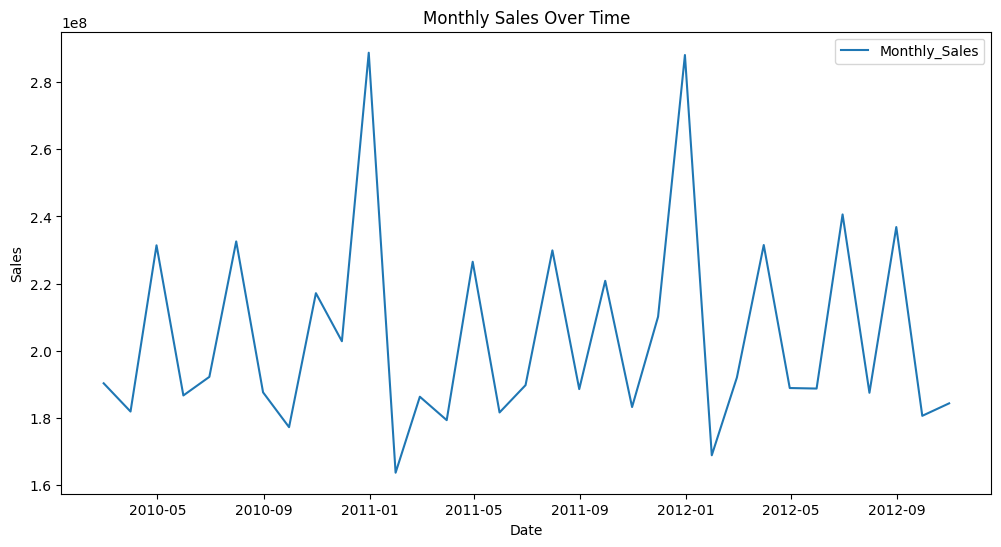

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label="Monthly_Sales")
plt.title("Monthly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

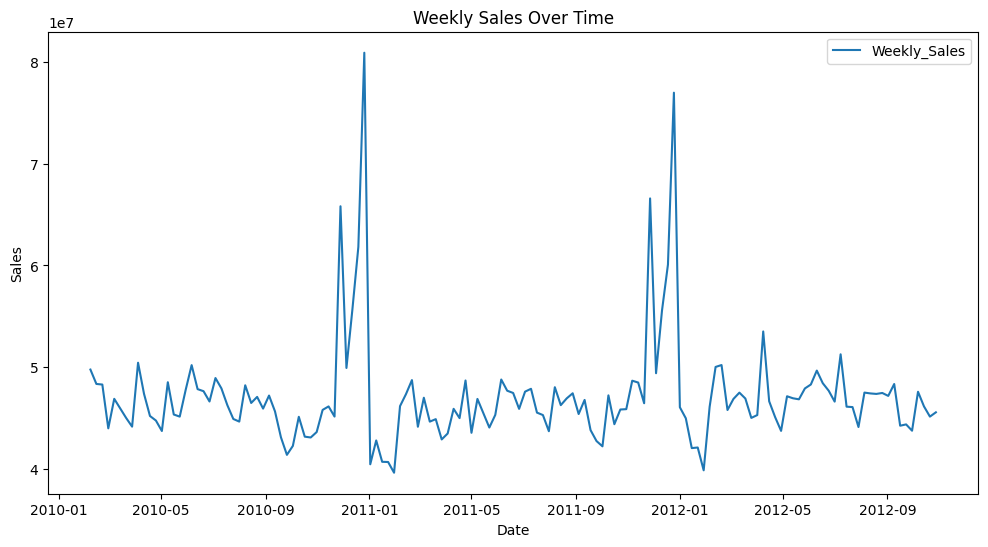

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales, label="Weekly_Sales")
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

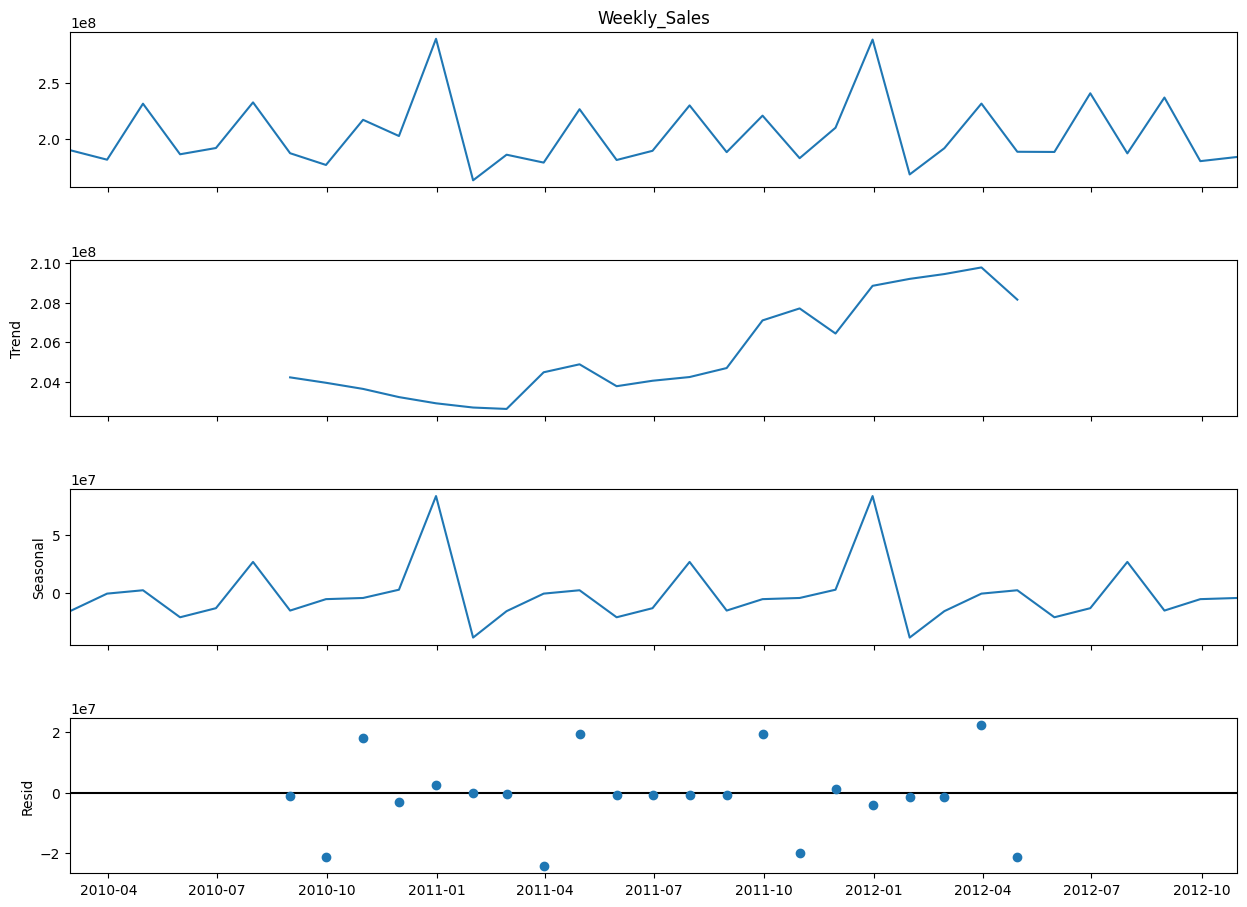

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(monthly_sales, model="additive")
fig = decomp.plot()
fig.set_size_inches(14, 10)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print("Augmented Dickey-Fuller Test Results")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")

    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    return result[1] < 0.05

is_stationary = check_stationarity(monthly_sales)
print(f"\nTime Series is {'stationary' if is_stationary else 'non-stationary'}")


Augmented Dickey-Fuller Test Results
ADF Statistic: -6.164473786749464
p-value: 7.044293727364691e-08
Critical Values:
	1%: -3.661428725118324
	5%: -2.960525341210433
	10%: -2.6193188033298647

Time Series is stationary


In [ ]:
# def find_best_arima(self, data, max_p=5, max_d=2, max_q=5):
#         """
#         Manual grid search for best ARIMA parameters
#         """
#         best_aic = float('inf')
#         best_params = None
#         best_model = None

#         print("Searching for best ARIMA parameters...")

#         for p in range(max_p + 1):
#             for d in range(max_d + 1):
#                 for q in range(max_q + 1):
#                     try:
#                         model = ARIMA(data, order=(p, d, q))
#                         fitted_model = model.fit()

#                         if fitted_model.aic < best_aic:
#                             best_aic = fitted_model.aic
#                             best_params = (p, d, q)
#                             best_model = fitted_model

#                     except Exception as e:
#                         continue

#         print(f"Best ARIMA parameters: {best_params}")
#         print(f"Best AIC: {best_aic}")

#         self.best_params = best_params
#         self.fitted_model = best_model

#         return best_params, best_model

In [ ]:
# auto_model = auto_sarima(monthly_sales, start_p=0, start_q=0, max_p=5, max_q=5, m=12, seasonal=True, d=None, trace=True, error_action="ignore", suppress_warnings=True, stepwise=True)

In [ ]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

def auto_sarima_alternative(data,
                          start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          m=12, seasonal=True,
                          d=None, D=None,
                          trace=True,
                          error_action="ignore",
                          stepwise=True,
                          information_criterion='aic',
                          max_order=10):

    # Convert to pandas Series if needed
    if not isinstance(data, pd.Series):
        data = pd.Series(data)

    # Remove any NaN values
    data = data.dropna()

    if trace:
        print("Performing stepwise search to minimize {}...".format(information_criterion.upper()))
        print(f"Data length: {len(data)}")

    # Auto-determine differencing orders if not provided
    if d is None:
        d = determine_differencing_order(data, trace=trace)

    if D is None and seasonal:
        D = determine_seasonal_differencing_order(data, m, trace=trace)
    elif not seasonal:
        D = 0

    # Define parameter ranges
    p_range = range(start_p, max_p + 1)
    q_range = range(start_q, max_q + 1)

    if seasonal:
        P_range = range(0, min(3, max_p + 1))  # Usually 0-2 for seasonal P
        Q_range = range(0, min(3, max_q + 1))  # Usually 0-2 for seasonal Q
    else:
        P_range = [0]
        Q_range = [0]

    best_ic = float('inf')
    best_model = None
    best_order = None
    best_seasonal_order = None

    # Generate all combinations
    if stepwise:
        # Stepwise search (more efficient)
        param_combinations = stepwise_search(p_range, q_range, P_range, Q_range, d, D, m, max_order)
    else:
        # Full grid search
        param_combinations = list(product(p_range, [d], q_range, P_range, [D], Q_range))
        param_combinations = [(p, d, q, P, D, Q) for p, d, q, P, D, Q in param_combinations
                            if p + q + P + Q <= max_order]

    total_combinations = len(param_combinations)
    if trace:
        print(f"Fitting {total_combinations} models...")

    for i, (p, d_val, q, P, D_val, Q) in enumerate(param_combinations):
        try:
            # Fit SARIMA model
            order = (p, d_val, q)
            seasonal_order = (P, D_val, Q, m) if seasonal else (0, 0, 0, 0)

            model = SARIMAX(data,
                          order=order,
                          seasonal_order=seasonal_order,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            fitted_model = model.fit(disp=False)

            # Get information criterion
            if information_criterion == 'aic':
                ic_value = fitted_model.aic
            elif information_criterion == 'bic':
                ic_value = fitted_model.bic
            elif information_criterion == 'hqic':
                ic_value = fitted_model.hqic
            else:
                ic_value = fitted_model.aic

            if trace:
                print(f"SARIMA{order}x{seasonal_order} - {information_criterion.upper()}: {ic_value:.3f}")

            # Check if this is the best model so far
            if ic_value < best_ic:
                best_ic = ic_value
                best_model = fitted_model
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception as e:
            if error_action == "ignore":
                if trace:
                    print(f"SARIMA{(p, d_val, q)}x{(P, D_val, Q, m)} - Failed: {str(e)[:50]}")
                continue
            else:
                raise e

    if best_model is None:
        raise ValueError("No suitable model found. Try expanding parameter ranges.")

    if trace:
        print(f"\nBest model: SARIMA{best_order}x{best_seasonal_order}")
        print(f"Best {information_criterion.upper()}: {best_ic:.3f}")

    return best_model, best_order, best_seasonal_order

def determine_differencing_order(data, max_d=2, trace=False):
    """Determine optimal differencing order using ADF test"""
    for d in range(max_d + 1):
        if d == 0:
            diff_data = data
        else:
            diff_data = data.diff(periods=d).dropna()

        # Perform ADF test
        adf_result = adfuller(diff_data)
        p_value = adf_result[1]

        if trace:
            print(f"Testing d={d}: ADF p-value = {p_value:.4f}")

        # If p-value < 0.05, series is stationary
        if p_value < 0.05:
            if trace:
                print(f"Series is stationary with d={d}")
            return d

    if trace:
        print(f"Using maximum d={max_d}")
    return max_d

def determine_seasonal_differencing_order(data, m, max_D=1, trace=False):
    """Determine seasonal differencing order"""
    for D in range(max_D + 1):
        if D == 0:
            diff_data = data
        else:
            diff_data = data.diff(periods=m*D).dropna()

        if len(diff_data) < 2*m:  # Need enough data
            continue

        # Simple test for seasonal stationarity
        # You could implement a more sophisticated test here
        try:
            adf_result = adfuller(diff_data)
            p_value = adf_result[1]

            if trace:
                print(f"Testing seasonal D={D}: ADF p-value = {p_value:.4f}")

            if p_value < 0.05:
                if trace:
                    print(f"Seasonally stationary with D={D}")
                return D
        except:
            continue

    return 0

def stepwise_search(p_range, q_range, P_range, Q_range, d, D, m, max_order):
    """
    Implement a stepwise search similar to auto_arima
    Start with simple models and expand
    """
    # Start with simple models
    initial_models = [
        (0, d, 0, 0, D, 0),  # (0,d,0)(0,D,0)
        (1, d, 0, 0, D, 0),  # (1,d,0)(0,D,0)
        (0, d, 1, 0, D, 0),  # (0,d,1)(0,D,0)
        (1, d, 1, 0, D, 0),  # (1,d,1)(0,D,0)
    ]

    # Add seasonal variants if applicable
    if max(P_range) > 0 or max(Q_range) > 0:
        seasonal_models = [
            (0, d, 0, 1, D, 0),  # (0,d,0)(1,D,0)
            (0, d, 0, 0, D, 1),  # (0,d,0)(0,D,1)
            (1, d, 0, 1, D, 0),  # (1,d,0)(1,D,0)
            (0, d, 1, 0, D, 1),  # (0,d,1)(0,D,1)
        ]
        initial_models.extend(seasonal_models)

    # Generate more combinations around promising areas
    all_combinations = []
    for p in p_range:
        for q in q_range:
            for P in P_range:
                for Q in Q_range:
                    if p + q + P + Q <= max_order:
                        all_combinations.append((p, d, q, P, D, Q))

    # Combine initial models with full search, removing duplicates
    combined = list(set(initial_models + all_combinations))

    return combined


best_model, best_order, best_seasonal_order = auto_sarima_alternative(
        monthly_sales,
        start_p=0, start_q=0,
        max_p=5, max_q=5,
        m=12, seasonal=True,
        d=None,
        trace=True,
        error_action="ignore",
        stepwise=True
    )

Performing stepwise search to minimize AIC...
Data length: 33
Testing d=0: ADF p-value = 0.0000
Series is stationary with d=0
Testing seasonal D=0: ADF p-value = 0.0000
Seasonally stationary with D=0
Fitting 291 models...
SARIMA(4, 0, 1)x(0, 0, 0, 12) - AIC: 1099.170
SARIMA(4, 0, 1)x(2, 0, 2, 12) - AIC: 202.911
SARIMA(1, 0, 4)x(1, 0, 0, 12) - AIC: 748.570
SARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC: 747.850
SARIMA(5, 0, 0)x(2, 0, 1, 12) - AIC: 163.660
SARIMA(0, 0, 3)x(1, 0, 2, 12) - AIC: 214.650
SARIMA(3, 0, 3)x(1, 0, 0, 12) - AIC: 674.913
SARIMA(2, 0, 5)x(2, 0, 1, 12) - AIC: 278.142
SARIMA(2, 0, 2)x(2, 0, 1, 12) - AIC: 273.795
SARIMA(1, 0, 3)x(2, 0, 0, 12) - AIC: 306.821
SARIMA(1, 0, 0)x(2, 0, 0, 12) - AIC: 309.461
SARIMA(2, 0, 0)x(2, 0, 1, 12) - AIC: 272.947
SARIMA(5, 0, 2)x(2, 0, 1, 12) - AIC: 167.642
SARIMA(0, 0, 1)x(2, 0, 0, 12) - AIC: 369.378
SARIMA(0, 0, 2)x(2, 0, 1, 12) - AIC: 373.439
SARIMA(3, 0, 4)x(0, 0, 2, 12) - AIC: 164.612
SARIMA(5, 0, 3)x(0, 0, 0, 12) - AIC: 1062.065
SARIMA(0, 0

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
order = (1, 0, 5)
seasonal_order = (0, 0, 2, 12)
model = ARIMA(monthly_sales, order=order, seasonal_order=seasonal_order)
results = model.fit()

In [ ]:
per = 12
forecast = results.get_forecast(steps=per)
mean_forecast = forecast.predicted_mean

In [ ]:
conf_int_95 = forecast.conf_int(alpha=0.05)
conf_int_80 = forecast.conf_int(alpha=0.20)
conf_int_70 = forecast.conf_int(alpha=0.30)

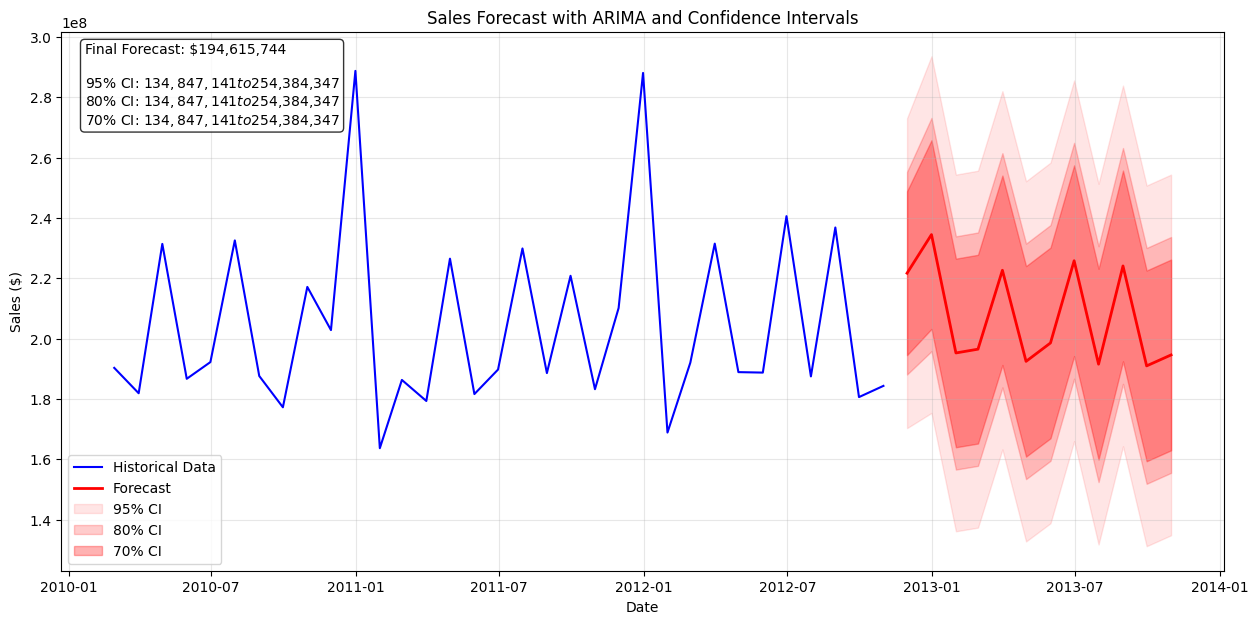

In [ ]:
plt.figure(figsize=(15, 7))

plt.plot(monthly_sales, label="Historical Data", color="blue")
plt.plot(mean_forecast, label="Forecast", color="red", linewidth=2)

plt.fill_between(mean_forecast.index,
                 conf_int_95.iloc[:, 0],
                 conf_int_95.iloc[:, 1],
                 color="red", alpha=0.1,
                 label="95% CI")

plt.fill_between(mean_forecast.index,
                 conf_int_80.iloc[:, 0],
                 conf_int_80.iloc[:, 1],
                 color="red", alpha=0.2,
                 label="80% CI")

plt.fill_between(mean_forecast.index,
                 conf_int_70.iloc[:, 0],
                 conf_int_70.iloc[:, 1],
                 color="red", alpha=0.3,
                 label="70% CI")

plt.title("Sales Forecast with ARIMA and Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()
plt.grid(True, alpha=0.3)

last_forecast = mean_forecast.iloc[-1]
ranges_95_lower = conf_int_95.iloc[-1, 0]
ranges_95_upper = conf_int_95.iloc[-1, 1]
ranges_80_lower = conf_int_95.iloc[-1, 0]
ranges_80_upper = conf_int_95.iloc[-1, 1]
ranges_70_lower = conf_int_95.iloc[-1, 0]
ranges_70_upper = conf_int_95.iloc[-1, 1]

info_text = f"Final Forecast: ${last_forecast:,.0f}\n\n" \
            f"95% CI: ${ranges_95_lower:,.0f} to ${ranges_95_upper:,.0f}\n" \
            f"80% CI: ${ranges_80_lower:,.0f} to ${ranges_80_upper:,.0f}\n" \
            f"70% CI: ${ranges_70_lower:,.0f} to ${ranges_70_upper:,.0f}"

plt.text(0.02, 0.98, info_text,
         transform=plt.gca().transAxes,
         verticalalignment="top",
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("\nModel Performance Metrics:")
mse = mean_squared_error(monthly_sales, results.fittedvalues)
rmse = np.sqrt(mse)
mae = mean_absolute_error(monthly_sales, results.fittedvalues)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

print("\nForecast Ranges for Final Period")
print(f"Point Forecast: ${last_forecast:,.2f}")
print("\nConfidence Intervals")
print(f"95% CI: ${ranges_95_lower:,.2f} to ${ranges_95_upper:,.2f}")
print(f"95% CI: ${ranges_80_lower:,.2f} to ${ranges_80_upper:,.2f}")
print(f"95% CI: ${ranges_70_lower:,.2f} to ${ranges_70_upper:,.2f}")

print("\nInterval Widths as Percentage of Forecast")
print(f"95% CI: +-{((ranges_95_upper-ranges_95_lower)/2/last_forecast*100):,.1f}%")
print(f"80% CI: +-{((ranges_80_upper-ranges_80_lower)/2/last_forecast*100):,.1f}%")
print(f"70% CI: +-{((ranges_70_upper-ranges_70_lower)/2/last_forecast*100):,.1f}%")

forecast_df = pd.DataFrame({
    "Forecast": mean_forecast,
    "95% Lower": conf_int_95.iloc[:, 0],
    "95% Lower": conf_int_95.iloc[:, 1],
    "80% Lower": conf_int_80.iloc[:, 0],
    "80% Lower": conf_int_80.iloc[:, 1],
    "70% Lower": conf_int_70.iloc[:, 0],
    "70% Lower": conf_int_70.iloc[:, 1],
})

print("\nDetailed Forecast with Confidence Intervals:")
print(forecast_df)


Model Performance Metrics:
Mean Squared Error (MSE): 548855449844007.25
Root Mean Squared Error (RMSE): 23427664.20
Mean Absolute Error (MAE): 16339530.36

Forecast Ranges for Final Period
Point Forecast: $194,615,743.61

Confidence Intervals
95% CI: $134,847,140.68 to $254,384,346.55
95% CI: $134,847,140.68 to $254,384,346.55
95% CI: $134,847,140.68 to $254,384,346.55

Interval Widths as Percentage of Forecast
95% CI: +-30.7%
80% CI: +-30.7%
70% CI: +-30.7%

Detailed Forecast with Confidence Intervals:
                Forecast     95% Lower     80% Lower     70% Lower
2012-11-30  2.217103e+08  2.730653e+08  2.552895e+08  2.488669e+08
2012-12-31  2.345087e+08  2.936185e+08  2.731585e+08  2.657661e+08
2013-01-31  1.952740e+08  2.543792e+08  2.339208e+08  2.265289e+08
2013-02-28  1.965259e+08  2.556690e+08  2.351975e+08  2.278009e+08
2013-03-31  2.226784e+08  2.820322e+08  2.614878e+08  2.540648e+08
2013-04-30  1.924853e+08  2.521769e+08  2.315155e+08  2.240504e+08
2013-05-31  1.985877e

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
stores_df = pd.read_csv('stores.csv')
features_df = pd.read_csv('features.csv')

In [35]:
with open('/content/WalmartRecruiting/helpers/data_loading.py', 'r') as f:
    file_content = f.read()
print(file_content)

# src/data_loader.py

import pandas as pd
from typing import Optional, List, Dict, Union
from pathlib import Path
from . import config


class WalmartDataLoader:
    """
    A data loader class for handling Walmart recruiting dataset files.
    Provides methods to load individual files or multiple files at once.
    """
    
    def __init__(self):
        """Initialize the data loader with available dataset mappings."""
        self.dataset_registry = {
            "stores": config.STORES_PATH,
            "features": config.FEATURES_PATH,
            "train": config.TRAIN_PATH,
            "test": config.TEST_PATH,
            "sample_submission": config.SAMPLE_SUBMISSION_PATH
        }
    
    def get_available_datasets(self) -> List[str]:
        """
        Returns a list of all available dataset names.
        
        Returns:
            List[str]: Available dataset identifiers.
        """
        return list(self.dataset_registry.keys())
    
    def load_single_dataset(self

In [37]:
with open('/content/WalmartRecruiting/helpers/data_preprocessing.py', 'r') as f:
    file_content = f.read()
print(file_content)

# src/data_preprocessor.py

import pandas as pd
from typing import Dict, Tuple, Optional, List
from . import config


class WalmartDataPreprocessor:
    """
    A comprehensive preprocessor for Walmart recruiting dataset.
    Handles merging, transformation, and aggregation operations.
    """
    
    def __init__(self):
        """Initialize the preprocessor."""
        self.processed_cache = {}
    
    def _combine_with_features(
        self, 
        primary_df: pd.DataFrame, 
        features_df: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Merge primary dataset with features data.
        
        Args:
            primary_df: Main dataset (train/test)
            features_df: Features dataset
            
        Returns:
            Merged DataFrame
        """
        merge_keys = ['Store', 'Date', 'IsHoliday']
        return pd.merge(primary_df, features_df, on=merge_keys, how='left')
    
    def _combine_with_stores(
        self, 
        primary_df: pd.DataFr